# Scope 3 emissions prediction

## Import Libraries and Dataset

In [421]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib
import matplotlib

sns.set_theme(style="whitegrid")  # Set theme globally
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  #Set font globally

# Load the dataset
file_path = "emissions_high_granularity (2).csv"
df = pd.read_csv(file_path)

# Create a folder to save plots
os.makedirs('eda_charts', exist_ok=True)

def save_plot(fig, filename, folder="eda_charts"):
    path = os.path.join(folder, filename)
    fig.savefig(path, bbox_inches='tight', dpi=300)
    plt.close(fig)

def ensure_dir(folder):
    os.makedirs(folder, exist_ok=True)

def save_model(model, filename='xgb_model.joblib'):
    joblib.dump(model, filename)

def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

## EDA

### Basic Information

In [425]:
# Display basic info
print("=== Dataset Info ===")
df.info()

# Display the first five rows
print("\n=== First 5 Rows ===")
print (df.head())

# Display the basic shape
print ("\n=== Shape of the Dataset === ")
df.shape

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19131 entries, 0 to 19130
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                19131 non-null  int64  
 1   parent_entity                       19131 non-null  object 
 2   parent_type                         19131 non-null  object 
 3   reporting_entity                    19131 non-null  object 
 4   commodity                           19131 non-null  object 
 5   production_value                    19131 non-null  float64
 6   production_unit                     19131 non-null  object 
 7   product_emissions_MtCO2             19131 non-null  float64
 8   flaring_emissions_MtCO2             19131 non-null  float64
 9   venting_emissions_MtCO2             19131 non-null  float64
 10  own_fuel_use_emissions_MtCO2        19131 non-null  float64
 11  fugitive_methane_emi

(19131, 15)

### Summary and Missing Data

In [428]:
# Summary of numerical features
print("\n=== Summary Statistics ===")
print(df.describe())

# Check for missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())


=== Summary Statistics ===
               year  production_value  product_emissions_MtCO2  \
count  19131.000000      19131.000000             19131.000000   
mean    1990.658617        278.272202                63.960646   
std       28.220693       1094.677245               154.102932   
min     1854.000000          0.000000                 0.000000   
25%     1976.000000          7.377672                 5.689288   
50%     1999.000000         37.026296                19.366329   
75%     2012.000000        182.400000                54.997023   
max     2023.000000      27192.000000              3412.456438   

       flaring_emissions_MtCO2  venting_emissions_MtCO2  \
count             19131.000000             19131.000000   
mean                  0.438136                 0.394694   
std                   1.647995                 1.664155   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0

### Outlier Treatment

In [431]:
numerical_cols = ['total_operational_emissions_MtCO2e', 'product_emissions_MtCO2', 'production_value']
df[numerical_cols] = df[numerical_cols].replace([np.inf, -np.inf], np.nan)

# Cap outliers using IQR method
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] > upper, upper, np.where(df[col] < lower, lower, df[col]))

### Visualisation Functions

In [434]:
def plot_numerical_distributions(df, numerical_cols):
    for col in numerical_cols:
        if col in df.columns:
            plot_df = df[[col]].dropna()

            if plot_df.empty:
                print(f"⚠️ No data available for plotting distribution of '{col}'. Skipping...")
                continue

            # Histogram + KDE
            plt.figure(figsize=(8, 4))
            sns.histplot(plot_df[col], kde=True, bins=30)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.savefig(f'eda_charts/distribution_{col}.png', dpi=300)
            plt.show()

            # Boxplot
            plt.figure(figsize=(8, 2))
            sns.boxplot(x=plot_df[col])
            plt.title(f"Boxplot of {col}")
            plt.tight_layout()
            plt.savefig(f'eda_charts/boxplot_{col}.png', dpi=300)
            plt.show()
        else:
            print(f"⚠️ Column '{col}' not found in the dataset. Skipping...")

def plot_categorical_analysis(df, categorical_col, numerical_cols, top_n=10, color_by=None):
    import matplotlib.pyplot as plt
    import seaborn as sns

    if categorical_col in df.columns:
        for col in numerical_cols:
            if col in df.columns:
                plot_df = df[[categorical_col, col] + ([color_by] if color_by else [])].dropna()

                if plot_df.empty:
                    print(f"⚠️ No data available for plotting {col} by {categorical_col}. Skipping...")
                    continue

                top_categories = (plot_df.groupby(categorical_col)[col]
                                  .median()
                                  .sort_values(ascending=False)
                                  .head(top_n)
                                  .index)

                plot_df = plot_df[plot_df[categorical_col].isin(top_categories)]

                fig, ax = plt.subplots(figsize=(12, 6))
                sns.boxplot(
                    y=categorical_col, 
                    x=col, 
                    data=plot_df, 
                    order=top_categories,
                    hue=color_by if color_by else None,
                    ax=ax
                )
                ax.set_title(f"{col} by {categorical_col} (Top {top_n})")
                ax.set_xlabel(col)
                ax.set_ylabel(categorical_col)
                plt.tight_layout()
                fig.savefig(f'eda_charts/{col}_by_{categorical_col}.png', dpi=300)
                plt.show()

                # Only add median labels if range is small enough to avoid rendering overflow
                try:
                    medians = plot_df.groupby(categorical_col)[col].median().loc[top_categories]
                    xlim = ax.get_xlim()
                    span = xlim[1] - xlim[0]
                    for idx, median in enumerate(medians):
                        if xlim[0] <= median <= xlim[1] and span < 1e5:
                            ax.text(median, idx, f"{median:.1f}", va='center', ha='left',
                                    fontsize=9, color='black')
                except Exception as e:
                    print(f"⚠️ Skipping median annotations due to plot scale: {e}")

        if not df[categorical_col].dropna().empty:
            fig, ax = plt.subplots(figsize=(10, 5))
            sns.countplot(y=categorical_col, data=df, order=df[categorical_col].value_counts().index, ax=ax)
            ax.set_title(f"Count of Records by {categorical_col}")
            plt.tight_layout()
            fig.savefig(f'eda_charts/count_by_{categorical_col}.png', dpi=300)
            plt.show()
        else:
            print(f"⚠️ No valid data to plot count for '{categorical_col}'.")
    else:
        print(f"⚠️ Categorical column '{categorical_col}' not found in the dataset. Skipping...")


### Distribution Analysis

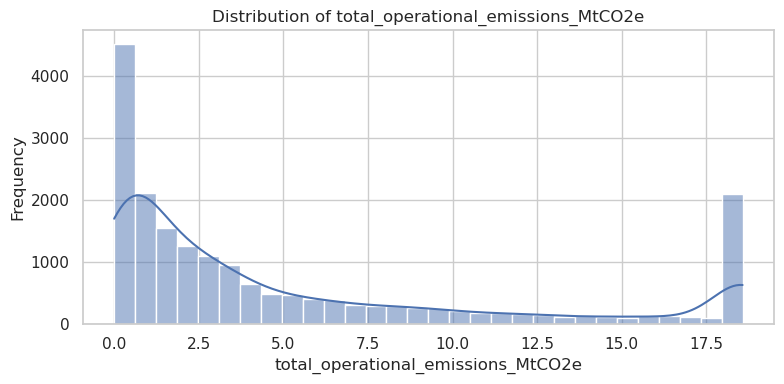

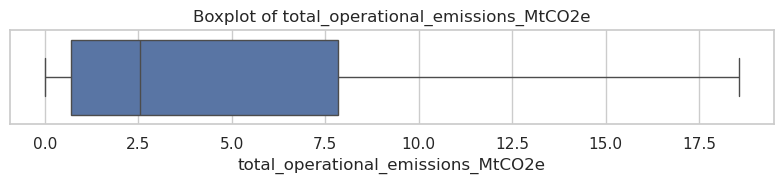

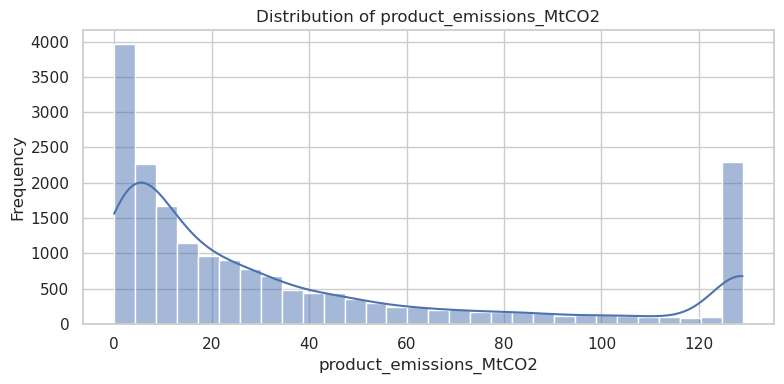

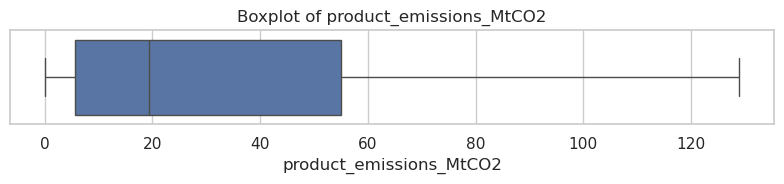

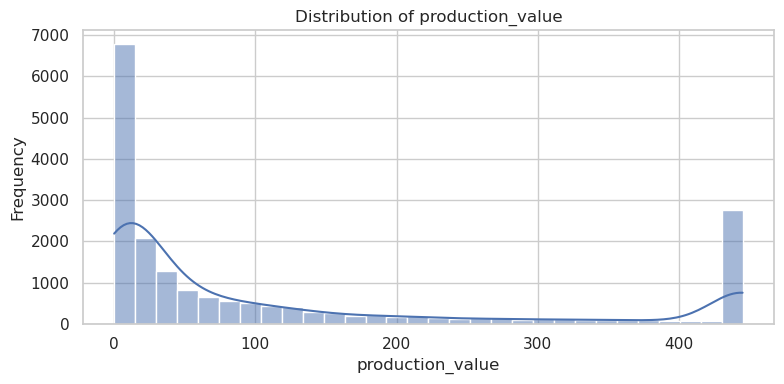

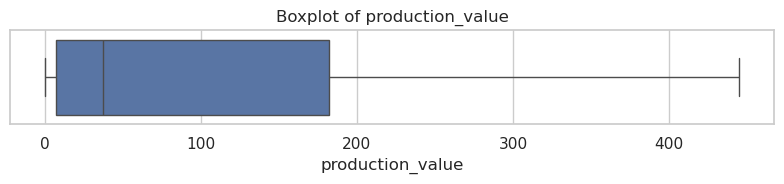

In [437]:
plot_numerical_distributions(df, numerical_cols)

### Grouped Statistics


=== Grouped Statistics by Commodity ===
                    total_operational_emissions_MtCO2e                      \
                                                 count      mean       std   
commodity                                                                    
Anthracite Coal                                 1007.0  3.763200  5.197552   
Bituminous Coal                                 2234.0  6.797128  6.399060   
Cement                                           344.0  0.000000  0.000000   
Lignite Coal                                    1370.0  2.821993  4.287354   
Metallurgical Coal                              1851.0  3.285979  4.238692   
Natural Gas                                     5071.0  7.236248  6.712083   
Oil & NGL                                       5724.0  4.797551  6.017053   
Sub-Bituminous Coal                              605.0  5.105927  6.091713   
Thermal Coal                                     925.0  5.121228  5.189403   

                      

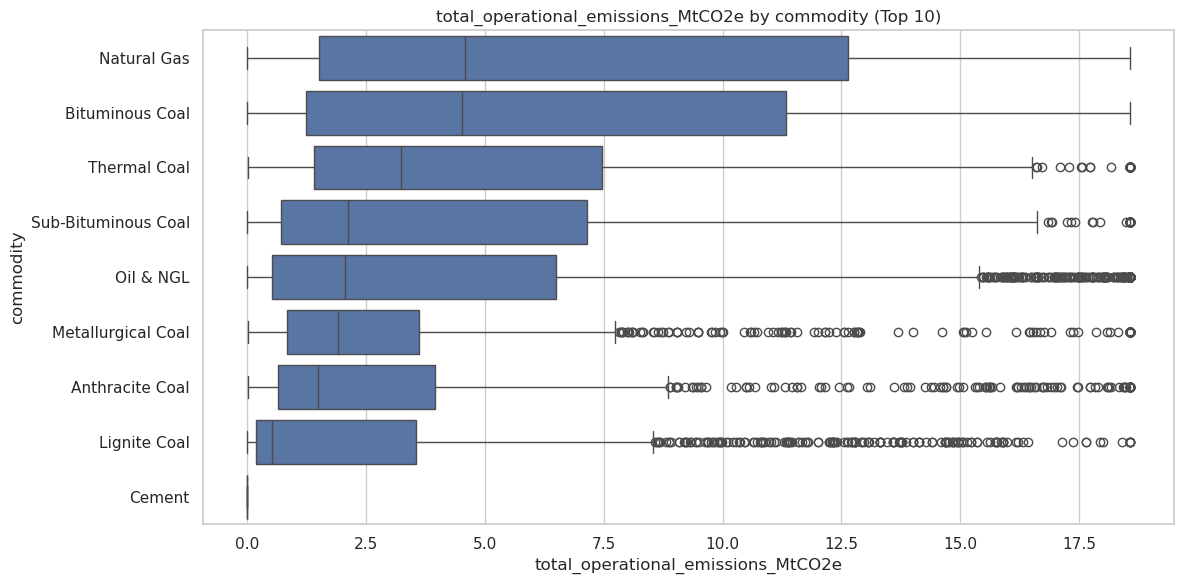

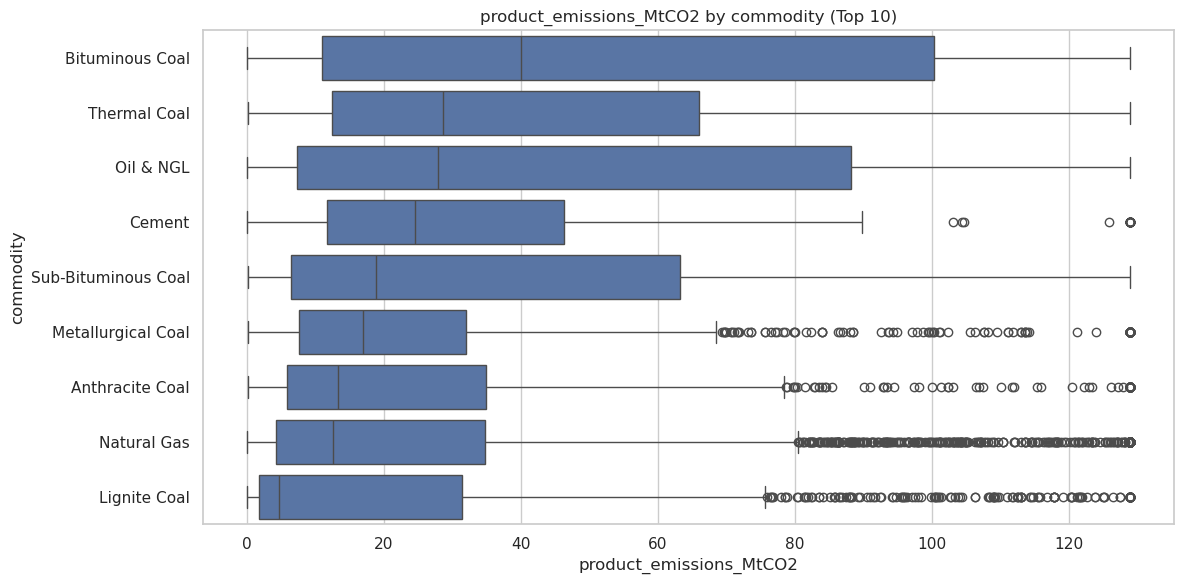

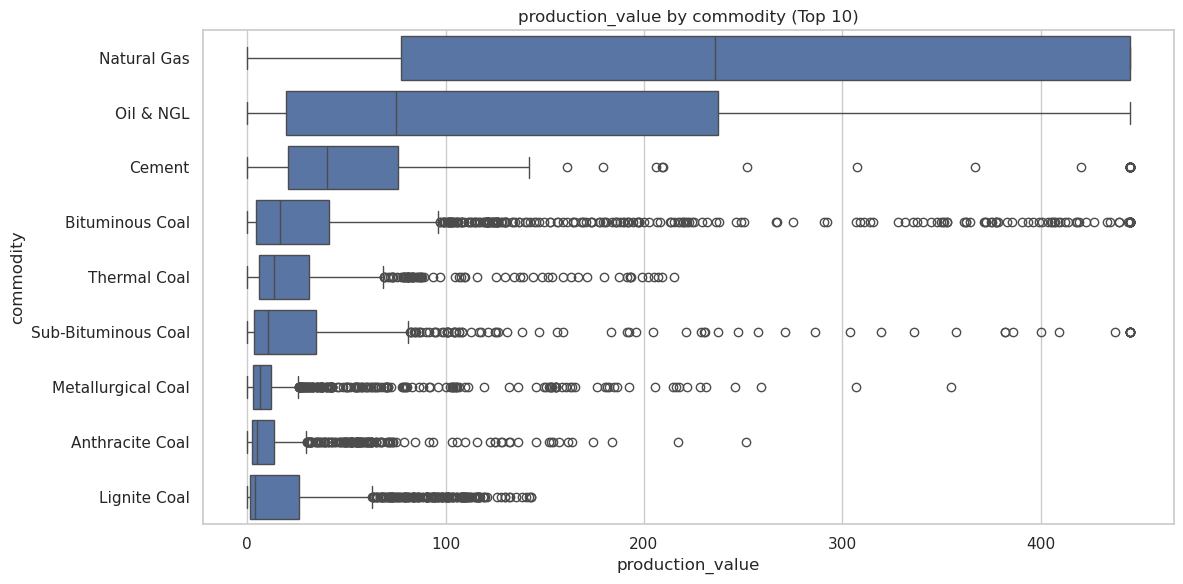

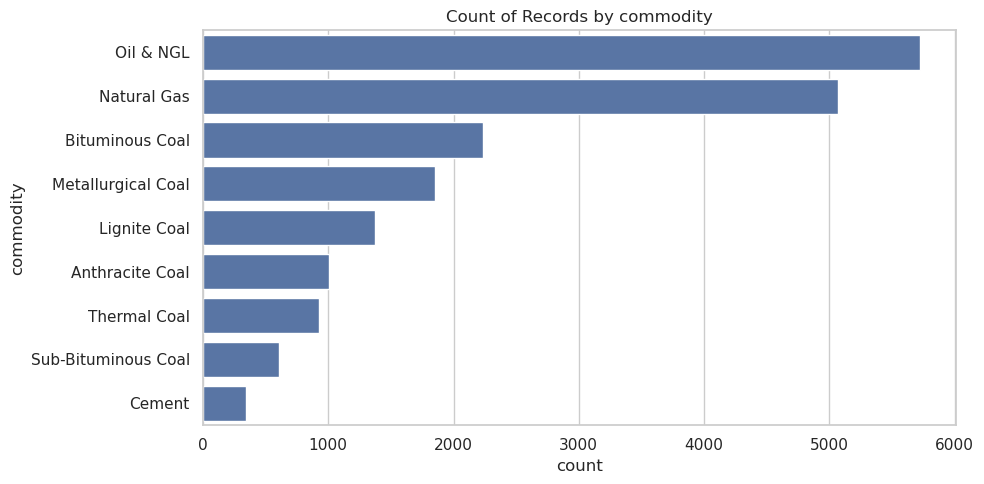

In [439]:
if 'commodity' in df.columns:
    print("\n=== Grouped Statistics by Commodity ===")
    print(df.groupby('commodity')[numerical_cols].describe())

plot_categorical_analysis(df, 'commodity', numerical_cols)

### Parent Entity Analysis

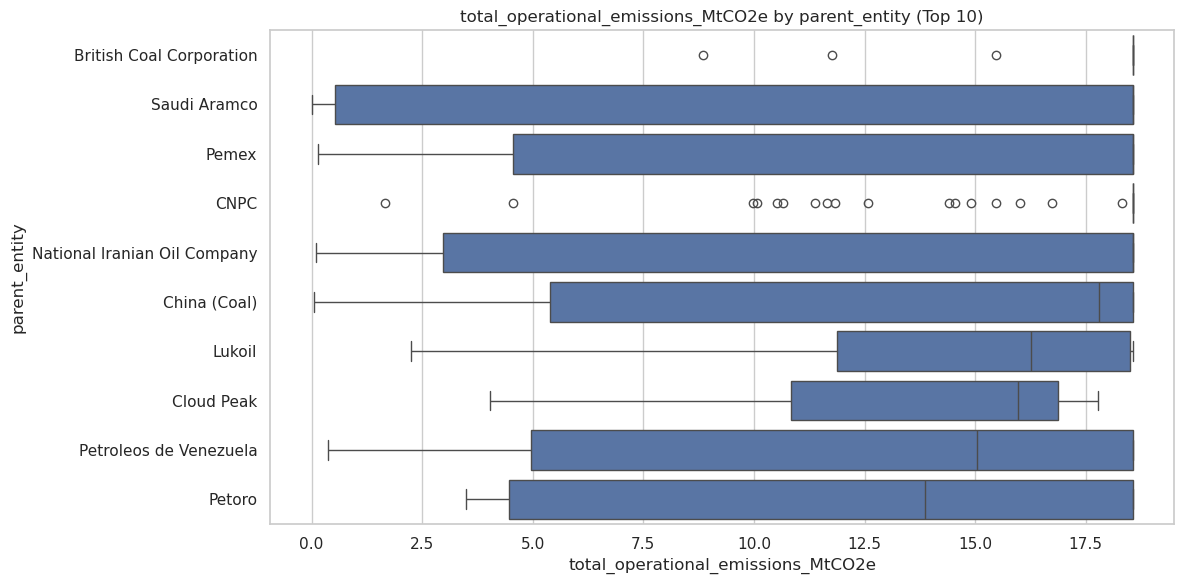

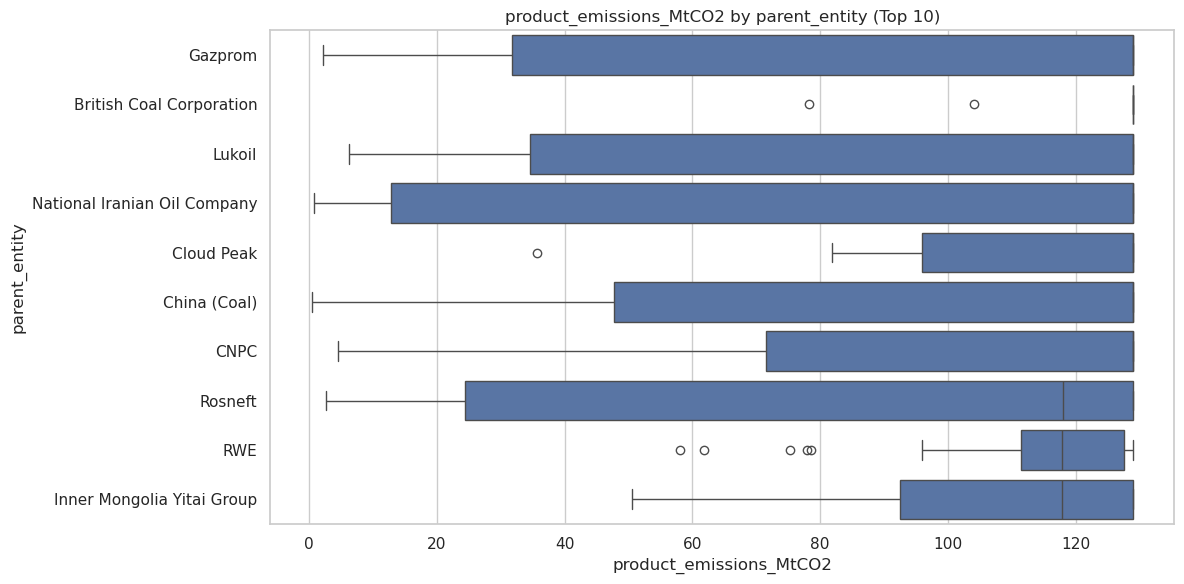

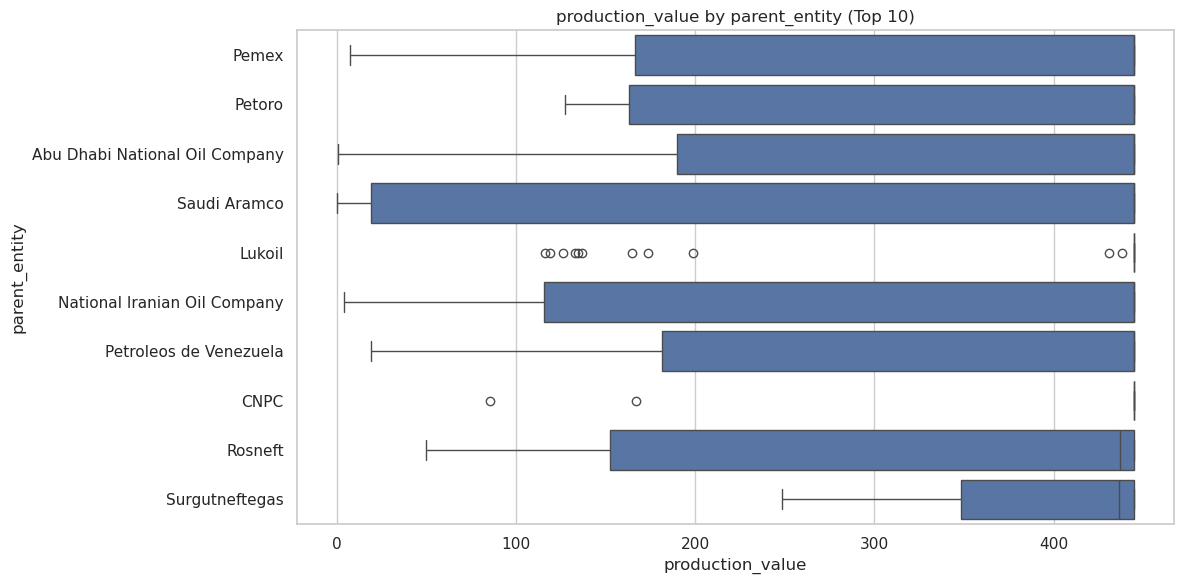

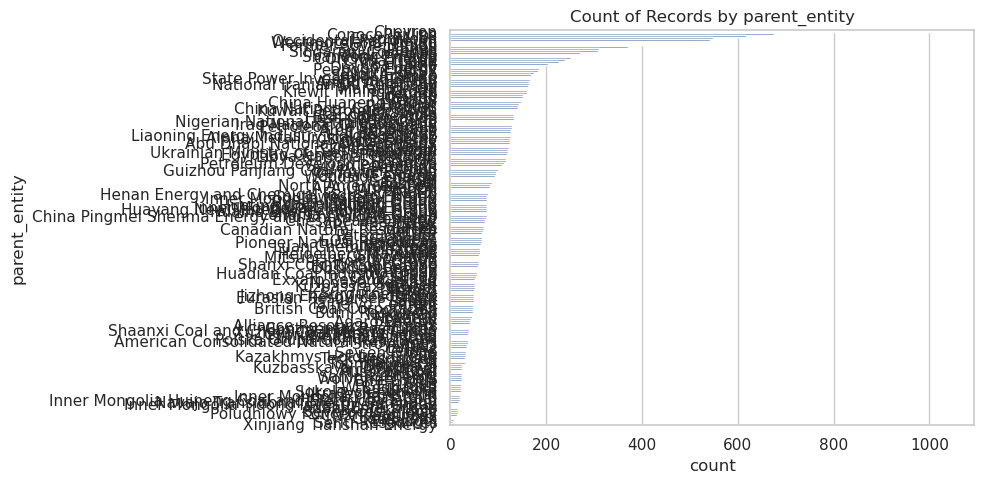

In [442]:
plot_categorical_analysis(df, 'parent_entity', numerical_cols)

### Production Volume vs Emissions

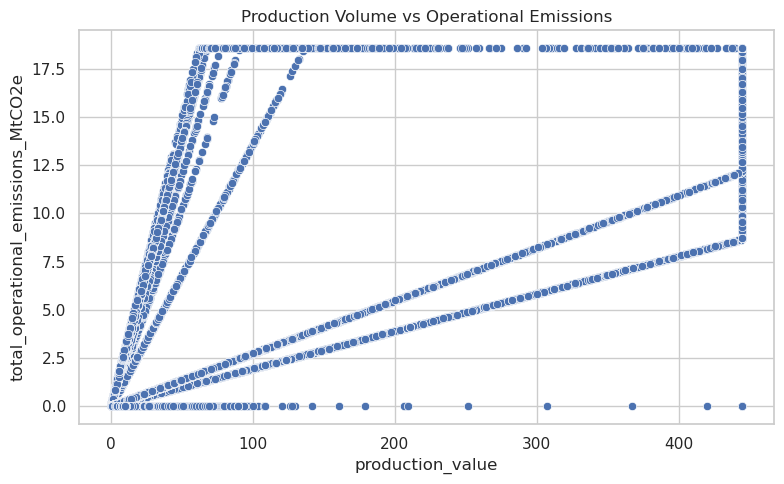

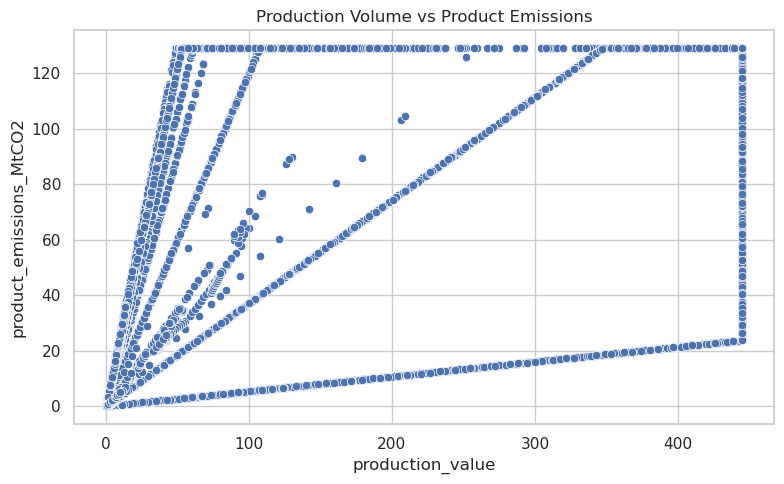

In [445]:
if all(col in df.columns for col in ['production_value', 'total_operational_emissions_MtCO2e', 'product_emissions_MtCO2']):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='production_value', y='total_operational_emissions_MtCO2e', data=df)
    plt.title("Production Volume vs Operational Emissions")
    plt.tight_layout()
    plt.savefig('eda_charts/production_vs_operational.png', dpi=300)
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='production_value', y='product_emissions_MtCO2', data=df)
    plt.title("Production Volume vs Product Emissions")
    plt.tight_layout()
    plt.savefig('eda_charts/production_vs_product.png', dpi=300)
    plt.show()

### Correlation Matrix


=== Correlation Matrix ===
                                        year  production_value  \
year                                1.000000          0.144611   
production_value                    0.144611          1.000000   
product_emissions_MtCO2             0.175216          0.574459   
flaring_emissions_MtCO2             0.032773          0.413690   
venting_emissions_MtCO2             0.070158          0.422866   
own_fuel_use_emissions_MtCO2        0.064431          0.335183   
fugitive_methane_emissions_MtCO2e   0.081862          0.411929   
total_operational_emissions_MtCO2e  0.185869          0.769205   
total_emissions_MtCO2e              0.079078          0.453661   

                                    product_emissions_MtCO2  \
year                                               0.175216   
production_value                                   0.574459   
product_emissions_MtCO2                            1.000000   
flaring_emissions_MtCO2                            0.447116

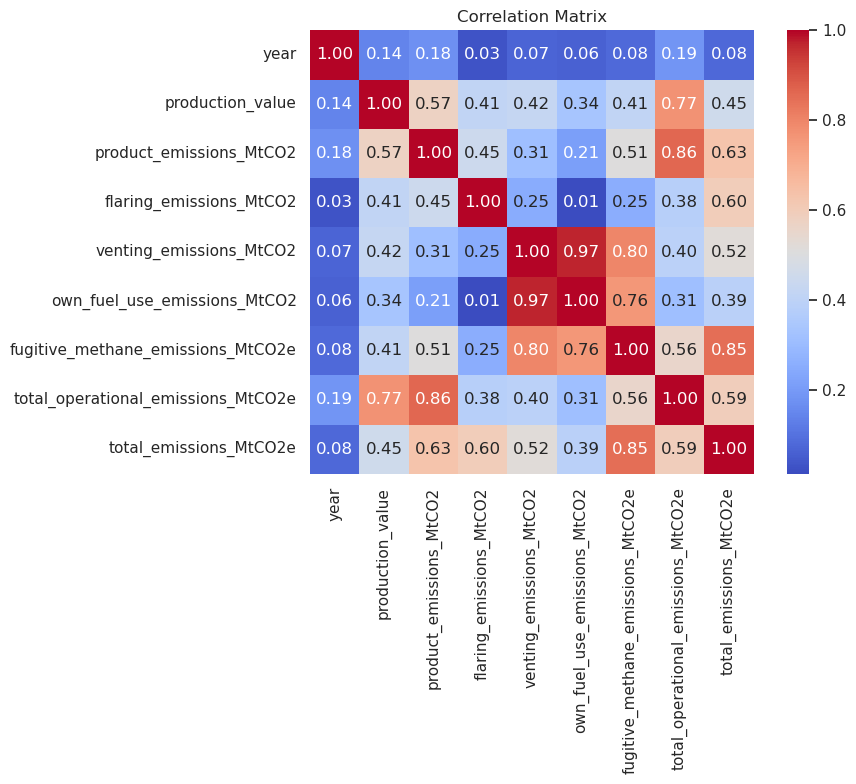

In [449]:
corr_matrix = df.select_dtypes(include='number').corr()

print("\n=== Correlation Matrix ===")
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.savefig('eda_charts/correlation_matrix.png', dpi=300)
plt.show()

### Time Series Analysis

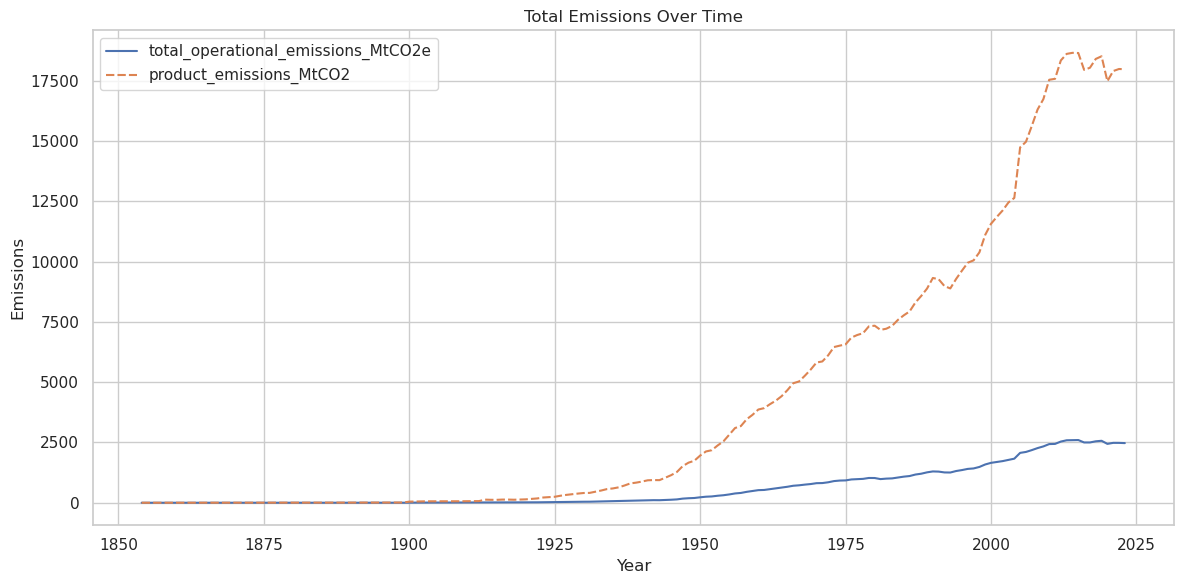

In [452]:
time_col = 'year'

if time_col in df.columns:
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df = df.dropna(subset=[time_col])
    yearly_emissions = df.groupby(time_col)[['total_operational_emissions_MtCO2e', 'product_emissions_MtCO2']].sum()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_emissions)
    plt.title("Total Emissions Over Time")
    plt.xlabel("Year")
    plt.ylabel("Emissions")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('eda_charts/emissions_over_time.png', dpi=300)
    plt.show()

### Additional Visuals

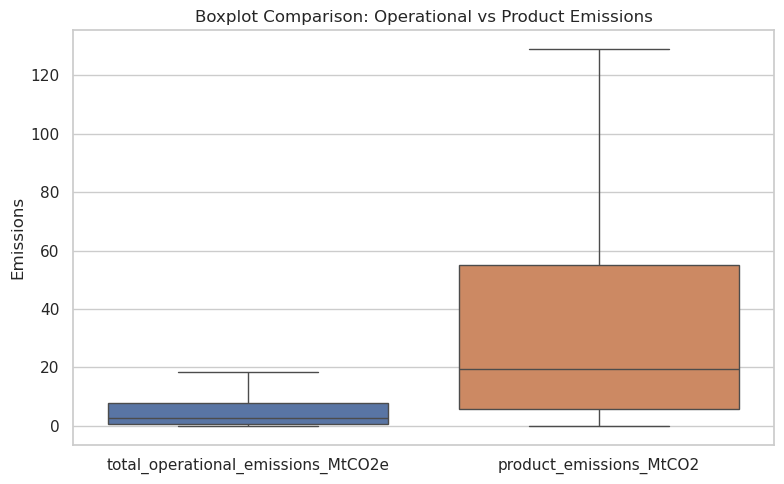

In [455]:
# Boxplot: Operational vs Product emissions comparison
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['total_operational_emissions_MtCO2e', 'product_emissions_MtCO2']])
plt.title("Boxplot Comparison: Operational vs Product Emissions")
plt.ylabel("Emissions")
plt.tight_layout()
plt.savefig('eda_charts/boxplot_operational_vs_product.png', dpi=300)
plt.show()

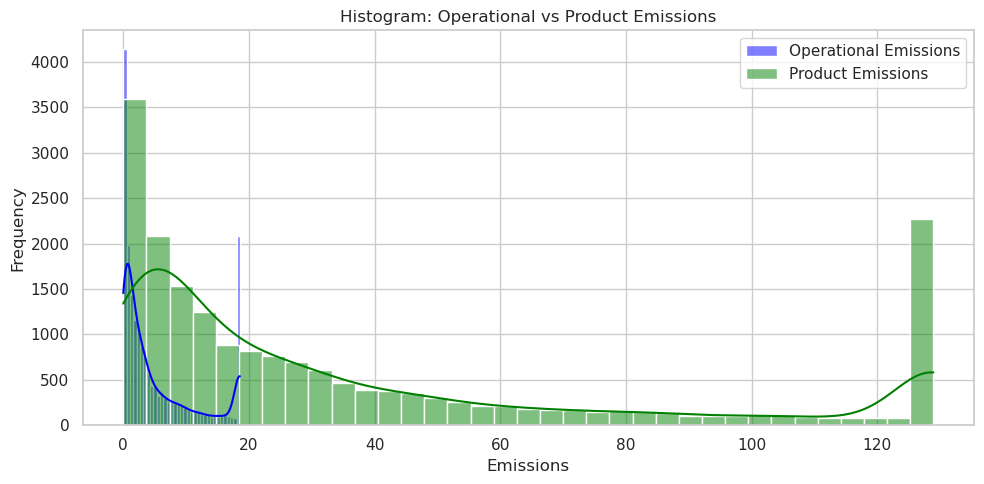

In [457]:
# Histogram Overlay: Operational vs Product emissions
plt.figure(figsize=(10, 5))
sns.histplot(df['total_operational_emissions_MtCO2e'], kde=True, label='Operational Emissions', color='blue', alpha=0.5)
sns.histplot(df['product_emissions_MtCO2'], kde=True, label='Product Emissions', color='green', alpha=0.5)
plt.legend()
plt.title("Histogram: Operational vs Product Emissions")
plt.xlabel("Emissions")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('eda_charts/histogram_operational_vs_product.png', dpi=300)
plt.show()

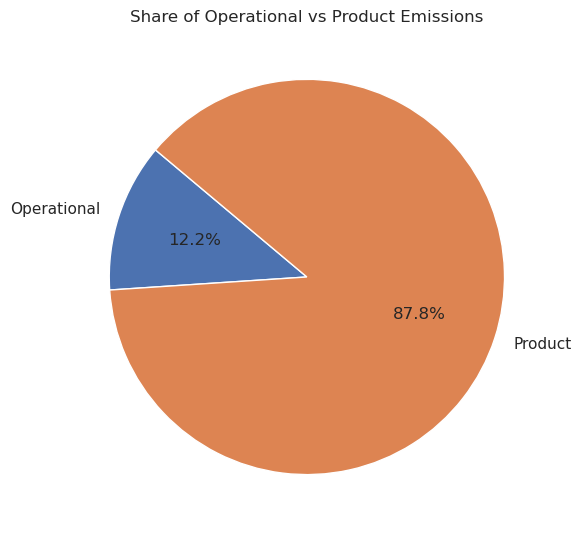

In [459]:
# Pie Chart: Share of Operational vs Product Emissions
total_op = df['total_operational_emissions_MtCO2e'].sum()
total_prod = df['product_emissions_MtCO2'].sum()

plt.figure(figsize=(6, 6))
plt.pie([total_op, total_prod], labels=['Operational', 'Product'], autopct='%1.1f%%', startangle=140)
plt.title("Share of Operational vs Product Emissions")
plt.tight_layout()
plt.savefig('eda_charts/piechart_operational_vs_product.png', dpi=300)
plt.show()

## Data Preprocessing

### Missing and Zero Data

In [463]:
# ===== Basic Preprocessing: Handle missing values and zeros =====
def handle_missing_values(df):
    df = df.copy()

    print("\n=== Missing Data Summary BEFORE Cleaning ===")
    missing_before = df.isnull().sum()
    print(missing_before)
    print(f"Total records before cleaning: {len(df)}")

    # Visualise missing data heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="YlOrRd")
    plt.title("Missing Values Heatmap - Before Cleaning")
    plt.tight_layout()
    plt.savefig("eda_charts/missing_heatmap_before.png", dpi=300)
    plt.close()

    critical_cols = ['production_value', 'product_emissions_MtCO2']
    df = df.dropna(subset=[col for col in critical_cols if col in df.columns])

    categorical_cols = ['commodity', 'parent_entity', 'parent_type', 'reporting_entity']
    for col in categorical_cols:
        if col in df.columns:
            mode_val = df[col].mode(dropna=True)
            if not mode_val.empty:
                df[col] = df[col].fillna(mode_val[0])

    if 'year' in df.columns:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df['year'] = df['year'].fillna(df['year'].median())

    for col in df.columns:
        if df[col].isnull().mean() > 0.7:
            print(f"Dropping column '{col}' due to >70% missing.")
            df = df.drop(columns=col)

    print("\n=== Missing Data Summary AFTER Cleaning ===")
    missing_after = df.isnull().sum()
    print(missing_after)
    print(f"Total records after cleaning: {len(df)}")

    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
    plt.title("Missing Values Heatmap - After Cleaning")
    plt.tight_layout()
    plt.savefig("eda_charts/missing_heatmap_after.png", dpi=300)
    plt.close()

    missing_comparison = pd.DataFrame({
        'Before': missing_before,
        'After': missing_after
    })
    missing_comparison = missing_comparison[missing_comparison.sum(axis=1) > 0]
    missing_comparison.plot(kind='bar', figsize=(14, 6))
    plt.title('Missing Values per Column: Before vs After Cleaning')
    plt.ylabel('Missing Count')
    plt.tight_layout()
    plt.savefig("eda_charts/missing_comparison_barplot.png", dpi=300)
    plt.close()

    # ===== Handle Zero Values =====
    numeric_cols = [
        'production_value',
        'product_emissions_MtCO2',
        'flaring_emissions_MtCO2',
        'venting_emissions_MtCO2',
        'own_fuel_use_emissions_MtCO2',
        'fugitive_methane_emissions_MtCO2e'
    ]

    zero_before = df[numeric_cols].isin([0]).sum()
    print("\n=== Zero Values Summary BEFORE Replacement ===")
    print(zero_before)

    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].replace(0, np.nan)
            df[col] = df[col].fillna(df[col].median())

    zero_after = df[numeric_cols].isin([0]).sum()
    print("\n=== Zero Values Summary AFTER Replacement ===")
    print(zero_after)

    zero_comparison = pd.DataFrame({
        'Before': zero_before,
        'After': zero_after
    })
    zero_comparison = zero_comparison[zero_comparison.sum(axis=1) > 0]
    zero_comparison.plot(kind='bar', figsize=(14, 6))
    plt.title('Zero Values per Column: Before vs After Replacement')
    plt.ylabel('Zero Count')
    plt.tight_layout()
    plt.savefig("eda_charts/zero_comparison_barplot.png", dpi=300)
    plt.close()

    return df

In [465]:
def compare_imputation_distributions(original_df, cleaned_df, columns):
    for col in columns:
        if col in original_df.columns and col in cleaned_df.columns:
            plt.figure(figsize=(10, 5))
            sns.kdeplot(original_df[col].dropna(), label='Original', fill=True)
            sns.kdeplot(cleaned_df[col].dropna(), label='Imputed/Cleaned', fill=True)
            plt.title(f"Distribution Comparison Before vs After Imputation: {col}")
            plt.xlabel(col)
            plt.ylabel("Density")
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'eda_charts/imputation_distribution_{col}.png', dpi=300)
            plt.show()

### Categorical Encoding

In [468]:
# ===== Categorical Encoding =====
def encode_categoricals(df, categorical_cols=None):
    df = df.copy()
    if categorical_cols is None:
        categorical_cols = ['commodity', 'parent_type', 'reporting_entity', 'parent_entity', 'production_unit', 'source']
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))
    return df

In [470]:
# === Plot Cardinality of Categorical Features ===
def plot_categorical_cardinality(df, categorical_cols):
    cardinality = {col: df[col].nunique() for col in categorical_cols if col in df.columns}
    if not cardinality:
        print("⚠️ No valid categorical columns found for cardinality analysis.")
        return

    cardinality_df = pd.DataFrame.from_dict(cardinality, orient='index', columns=['Unique Categories'])
    cardinality_df.sort_values('Unique Categories', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=cardinality_df['Unique Categories'], y=cardinality_df.index)
    plt.title("Cardinality of Categorical Variables")
    plt.xlabel("Number of Unique Categories")
    plt.ylabel("Categorical Feature")
    plt.tight_layout()
    plt.savefig('eda_charts/categorical_cardinality.png', dpi=300)
    plt.show()


### Feature Engineering

In [473]:
# ===== Feature Engineering =====
def create_emissions_intensity(df):
    df = df.copy()
    if all(col in df.columns for col in ['production_value', 'product_emissions_MtCO2']):
        df['product_emissions_intensity'] = df['product_emissions_MtCO2'] / (df['production_value'] + 1e-5)
    return df

### Feature Scaling

In [476]:
# ===== Feature Scaling =====
def scale_features(df, numerical_cols=None):
    df = df.copy()
    if numerical_cols is None:
        numerical_cols = ['production_value', 'product_emissions_MtCO2']
    scaler = MinMaxScaler()
    for col in numerical_cols:
        if col in df.columns:
            df[col] = scaler.fit_transform(df[[col]])
    return df

### Full Preprocessing Pipeline

In [479]:
# ===== Full Preprocessing Pipeline =====
def preprocess_emissions_data(df):
    df = handle_missing_values(df)
    df = encode_categoricals(df)
    df = create_emissions_intensity(df)
    df = scale_features(df)
    return df

### Model Training and Evaluation

In [482]:
# ===== Model Training and Evaluation =====
def train_xgboost_model(df, target_col, corr_threshold=0.05):
    # Automatically select top correlated features
    corr_matrix = df.corr()
    correlations = corr_matrix[target_col].abs().sort_values(ascending=False)
    feature_cols = correlations[1:][correlations[1:] > corr_threshold].index.tolist()

    # Remove any 'total_' columns to prevent data leakage
    feature_cols = [col for col in feature_cols if not col.startswith('total_') and col != target_col]

    X = df[feature_cols]
    y = df[target_col]

    print(f"Selected features: {feature_cols}")
    print(f"Training shape: {X.shape}, Target: {target_col}")

    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores, rmse_scores, r2_scores = [], [], []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)

        mae_scores.append(mean_absolute_error(y_val, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        r2_scores.append(r2_score(y_val, y_pred))

    print("\n=== Cross-Validation Results ===")
    print(f"MAE: {np.mean(mae_scores):.4f}")
    print(f"RMSE: {np.mean(rmse_scores):.4f}")
    print(f"R²: {np.mean(r2_scores):.4f}")

    joblib.dump(xgb_model, "eda_charts/model_xgboost.pkl")

    # Save barplot of metrics
    folds = [f"Fold {i+1}" for i in range(len(mae_scores))]
    x = np.arange(len(folds))
    width = 0.25
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, mae_scores, width, label='MAE')
    ax.bar(x, rmse_scores, width, label='RMSE')
    ax.bar(x + width, r2_scores, width, label='R²')
    ax.set_xlabel('Fold')
    ax.set_ylabel('Score')
    ax.set_title('Cross-Validation Metrics per Fold')
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.legend()
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    fig.tight_layout()
    plt.savefig('eda_charts/crossval_metrics_barplot.png', dpi=300)
    plt.close()

    # Save final fold for diagnostics
    final_X_val = X_val
    final_y_val = y_val
    final_y_pred = y_pred

    return xgb_model, feature_cols, mae_scores, rmse_scores, r2_scores, final_X_val, final_y_val, final_y_pred

In [484]:
df_clean = preprocess_emissions_data(df)


=== Missing Data Summary BEFORE Cleaning ===
year                                   0
parent_entity                          0
parent_type                            0
reporting_entity                       0
commodity                              0
production_value                       0
production_unit                        0
product_emissions_MtCO2                0
flaring_emissions_MtCO2                0
venting_emissions_MtCO2                0
own_fuel_use_emissions_MtCO2           0
fugitive_methane_emissions_MtCO2e      0
total_operational_emissions_MtCO2e     0
total_emissions_MtCO2e                 0
source                                67
dtype: int64
Total records before cleaning: 19131

=== Missing Data Summary AFTER Cleaning ===
year                                   0
parent_entity                          0
parent_type                            0
reporting_entity                       0
commodity                              0
production_value                       

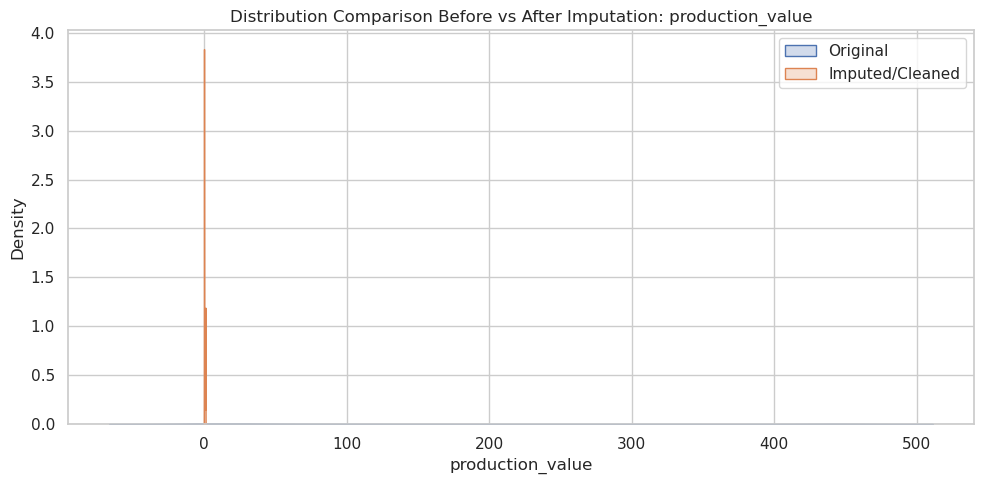

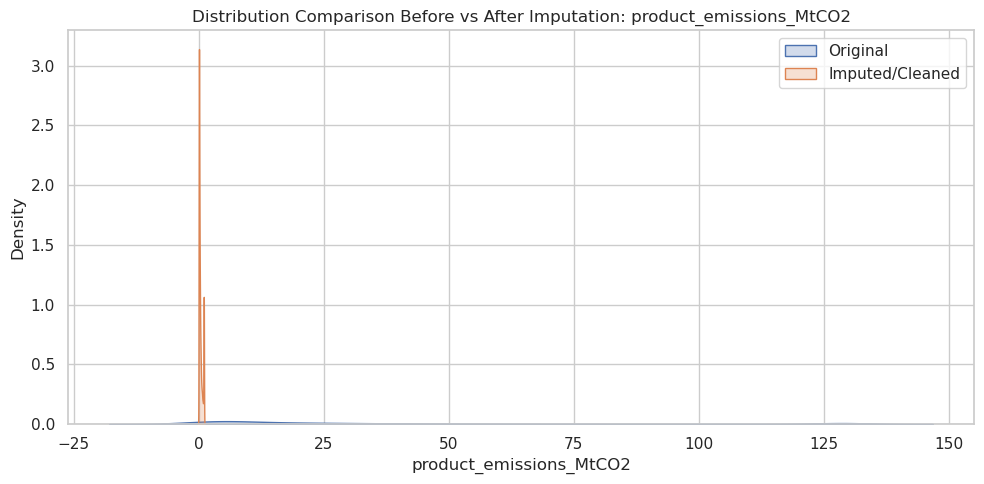

In [485]:
compare_imputation_distributions(df, df_clean, ['production_value', 'product_emissions_MtCO2'])

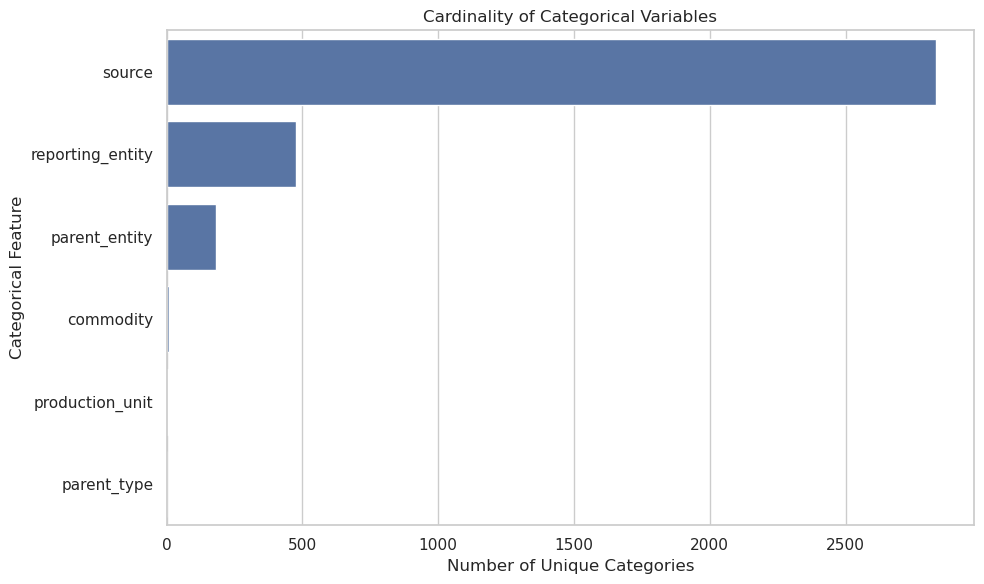

In [486]:
categorical_cols = ['commodity', 'parent_type', 'reporting_entity', 'parent_entity', 'production_unit', 'source']
plot_categorical_cardinality(df, categorical_cols)

In [488]:
df_clean.head()

,year,parent_entity,parent_type,reporting_entity,commodity,production_value,production_unit,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,source,product_emissions_intensity
0,2005,145,2,357,1,0.055411,3,0.466251,0.08842,0.187421,0.72233,6.792537,6.792537,66.919812,21,2.438646
1,2006,145,2,357,1,0.069490,3,0.584706,0.08842,0.187421,0.72233,8.518221,8.518221,83.921179,26,2.438646
2,2007,145,2,357,1,0.090365,3,0.760345,0.08842,0.187421,0.72233,11.076993,11.076993,109.130102,29,2.438646
3,2008,145,2,357,1,0.108597,3,0.913746,0.08842,0.187421,0.72233,13.311786,13.311786,131.147198,34,2.438646
4,2009,145,2,357,1,0.127656,3,1.000000,0.08842,0.187421,0.72233,15.647960,15.647960,154.163097,39,2.270398


In [489]:
def plot_log_transformation(df, col):
    if col in df.columns:
        original = df[col].dropna()
        log_transformed = np.log1p(original)  # log(1 + x) avoids issues with 0

        plt.figure(figsize=(10, 5))
        sns.kdeplot(original, label='Original', fill=True, alpha=0.4)
        sns.kdeplot(log_transformed, label='Log-Transformed', fill=True, alpha=0.4)
        plt.title(f"Log Transformation of '{col}'")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'eda_charts/log_transformation_{col}.png', dpi=300)
        plt.show()
    else:
        print(f"⚠️ Column '{col}' not found in the dataset.")


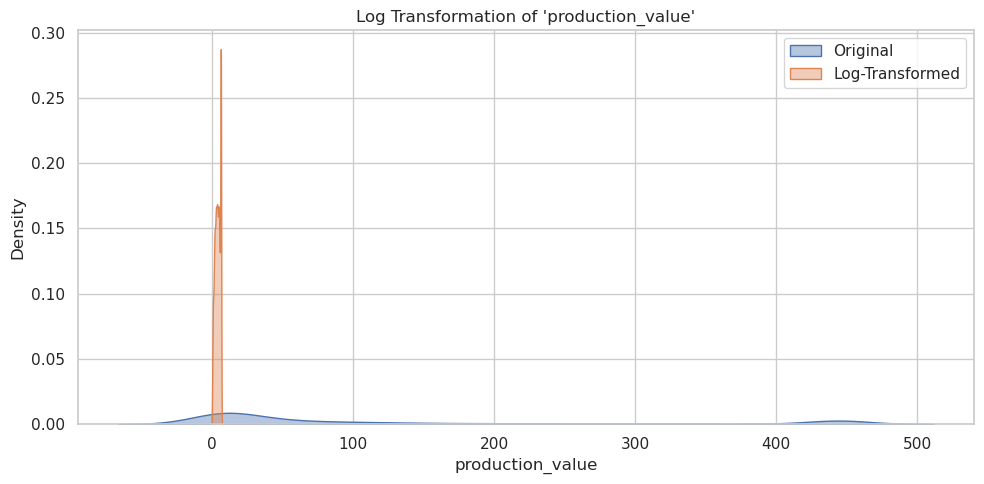

In [491]:
plot_log_transformation(df, 'production_value')

In [496]:
from sklearn.preprocessing import PolynomialFeatures

def plot_polynomial_expansion(df, features, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    if all(col in df.columns for col in features):
        X_poly = poly.fit_transform(df[features])
        feature_names = poly.get_feature_names_out(features)
        poly_df = pd.DataFrame(X_poly, columns=feature_names)

        # Correlation matrix heatmap of expanded features
        corr = poly_df.corr().abs()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, cmap="viridis", square=True)
        plt.title(f"Polynomial Feature Expansion (Degree {degree})")
        plt.tight_layout()
        plt.savefig(f'eda_charts/polynomial_expansion_degree_{degree}.png', dpi=300)
        plt.show()
    else:
        print("⚠️ One or more specified features are missing.")


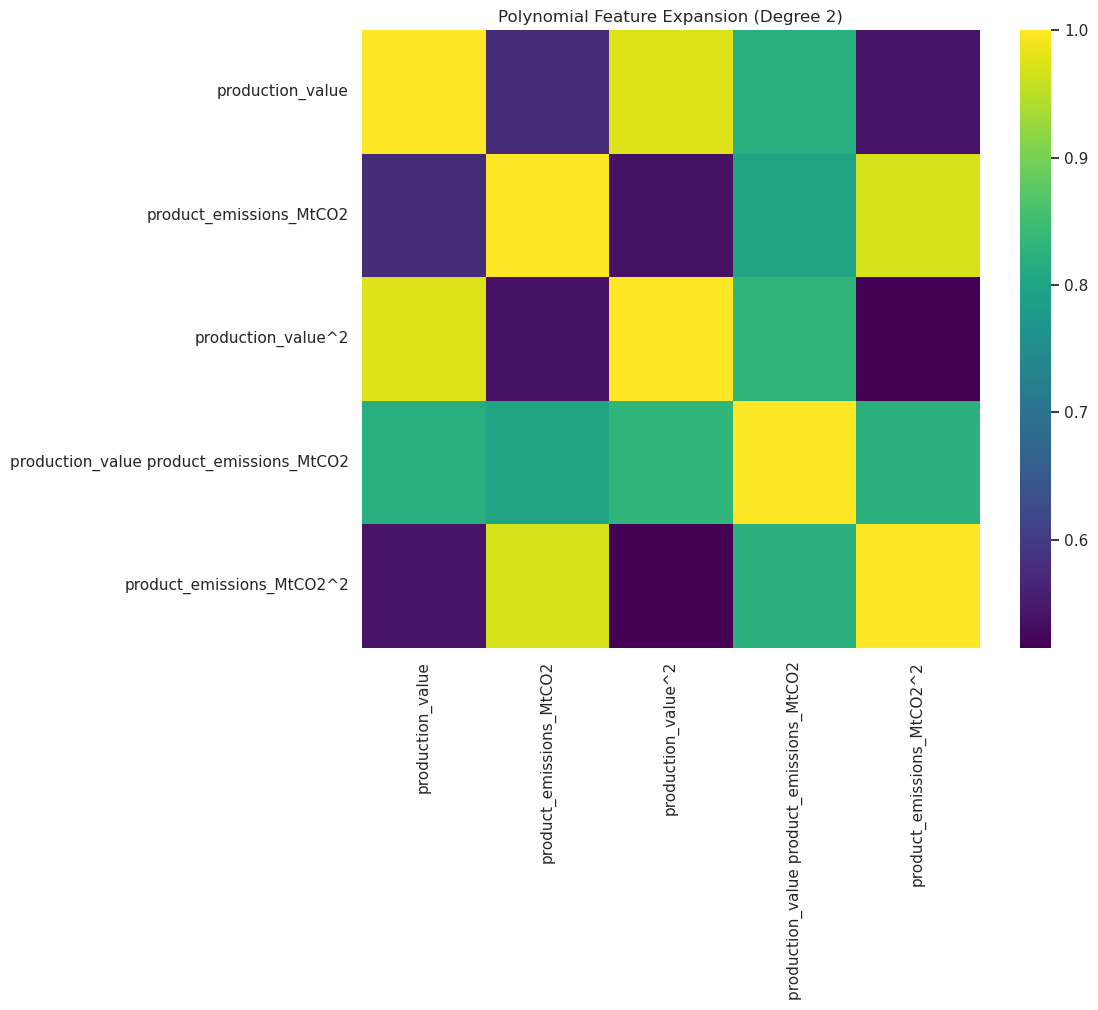

In [498]:
plot_polynomial_expansion(df, ['production_value', 'product_emissions_MtCO2'])

In [499]:
from sklearn.model_selection import train_test_split

def plot_train_test_distributions(df, target_col, stratify_col=None):
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[stratify_col] if stratify_col else None)

    # Numerical target distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(train_df[target_col], label='Train', fill=True, alpha=0.4)
    sns.kdeplot(test_df[target_col], label='Test', fill=True, alpha=0.4)
    plt.title("Target Distribution - Train vs Test")
    plt.xlabel(target_col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig("eda_charts/train_test_target_distribution.png", dpi=300)
    plt.show()

    # Example: categorical feature count comparison
    cat_col = 'commodity'
    if cat_col in df.columns:
        train_counts = train_df[cat_col].value_counts(normalize=True)
        test_counts = test_df[cat_col].value_counts(normalize=True)
        compare_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0)

        compare_df.plot(kind='bar', figsize=(12, 6))
        plt.title("Categorical Distribution (commodity): Train vs Test")
        plt.ylabel("Proportion")
        plt.tight_layout()
        plt.savefig("eda_charts/train_test_categorical_distribution.png", dpi=300)
        plt.show()


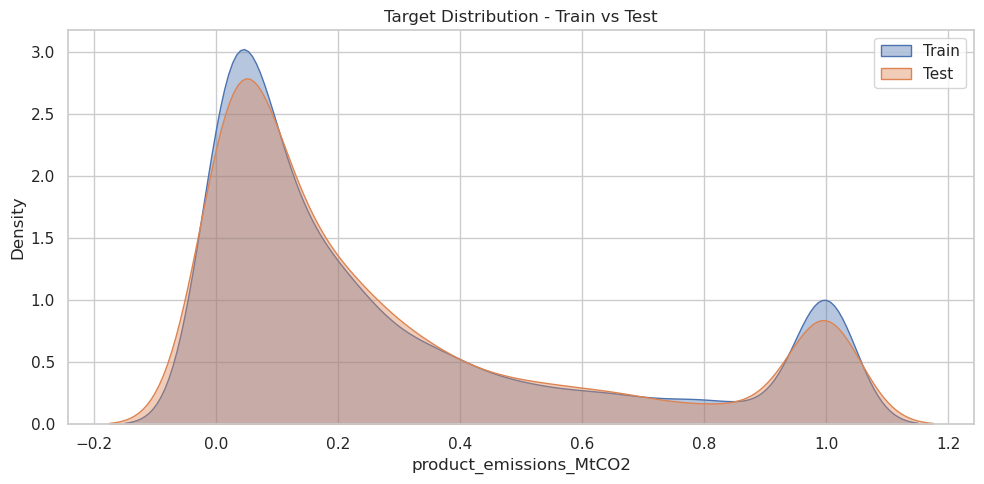

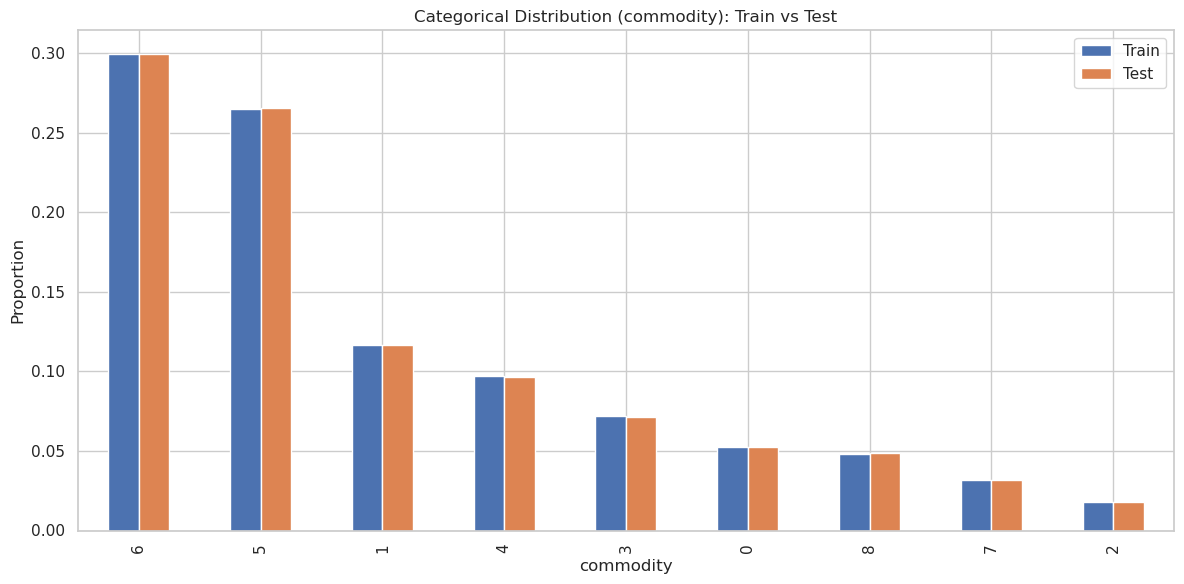

In [502]:
plot_train_test_distributions(df_clean, target_col='product_emissions_MtCO2', stratify_col='commodity')


In [503]:
def plot_feature_distribution_comparison(train_df, test_df, features):
    for col in features:
        if col in train_df.columns and col in test_df.columns:
            plt.figure(figsize=(10, 5))
            sns.kdeplot(train_df[col].dropna(), label='Train', fill=True, alpha=0.4)
            sns.kdeplot(test_df[col].dropna(), label='Test', fill=True, alpha=0.4)
            plt.title(f"Distribution of '{col}' - Train vs Test")
            plt.xlabel(col)
            plt.ylabel("Density")
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"eda_charts/feature_distribution_{col}_train_test.png", dpi=300)
            plt.show()


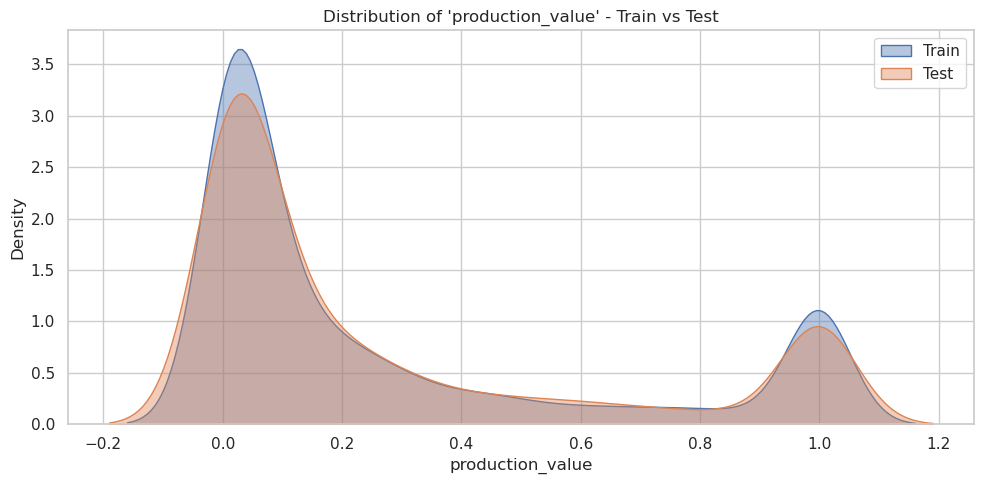

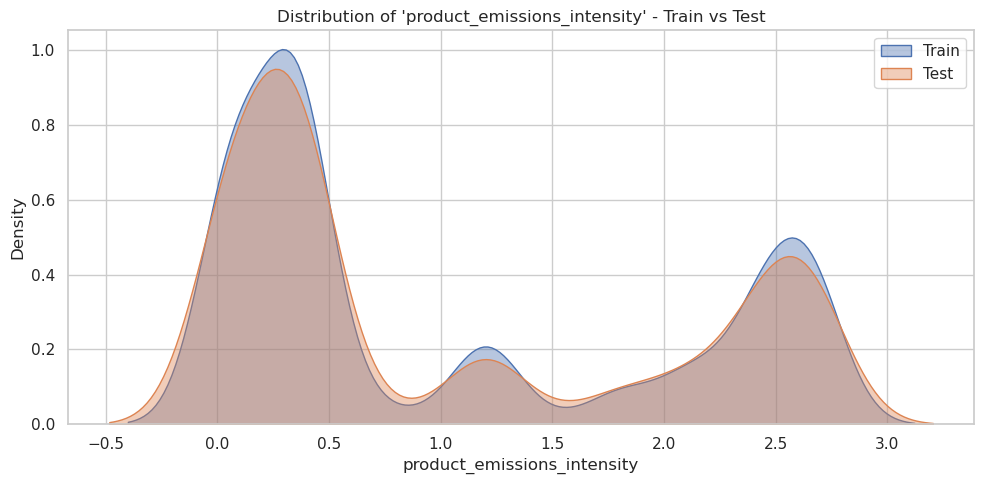

In [506]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_clean, test_size=0.3, random_state=42)

plot_feature_distribution_comparison(train_df, test_df, ['production_value', 'product_emissions_intensity'])


In [507]:
xgb_model, feature_cols, mae_scores, rmse_scores, r2_scores, X_val, y_val, y_pred = train_xgboost_model(df_clean, 'product_emissions_MtCO2')

Selected features: ['production_value', 'fugitive_methane_emissions_MtCO2e', 'flaring_emissions_MtCO2', 'venting_emissions_MtCO2', 'own_fuel_use_emissions_MtCO2', 'year', 'parent_type', 'production_unit', 'reporting_entity', 'parent_entity', 'product_emissions_intensity']
Training shape: (19131, 11), Target: product_emissions_MtCO2

=== Cross-Validation Results ===
MAE: 0.0017
RMSE: 0.0043
R²: 0.9998


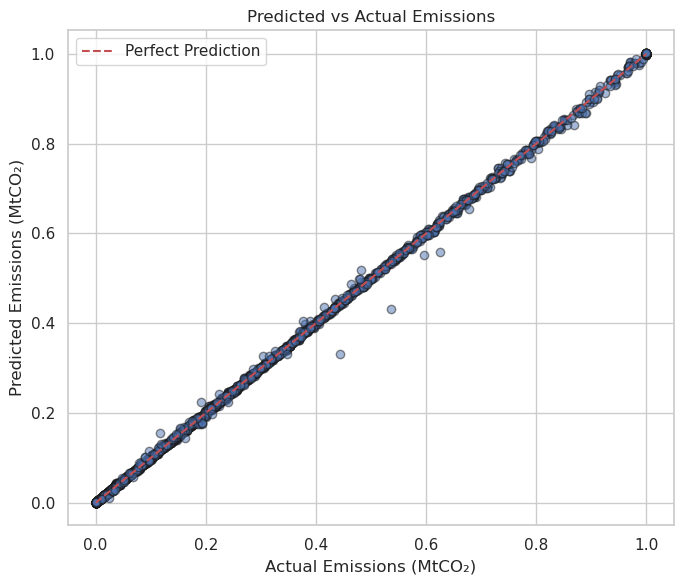

In [509]:
import matplotlib.pyplot as plt

# Final validation set (from last fold)
y_true = y_val
y_pred = xgb_model.predict(X_val)

plt.figure(figsize=(7, 6))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Emissions (MtCO₂)")
plt.ylabel("Predicted Emissions (MtCO₂)")
plt.title("Predicted vs Actual Emissions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("eda_charts/predicted_vs_actual.png", dpi=300)
plt.show()


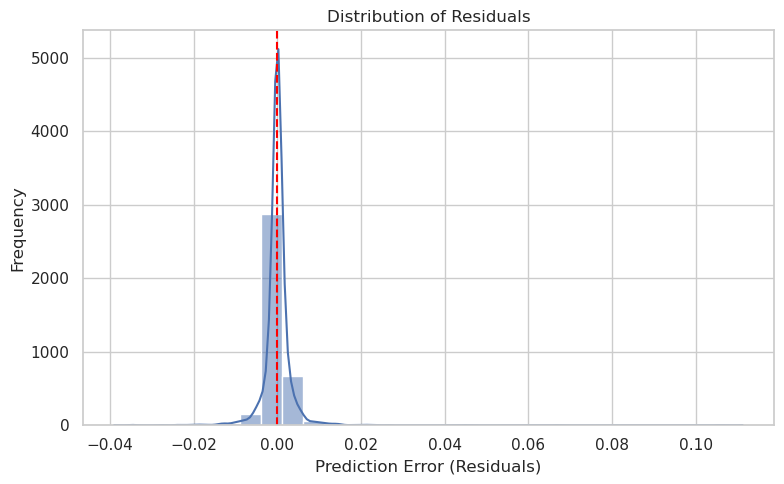

In [510]:
import seaborn as sns

residuals = y_true - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("eda_charts/residual_distribution.png", dpi=300)
plt.show()


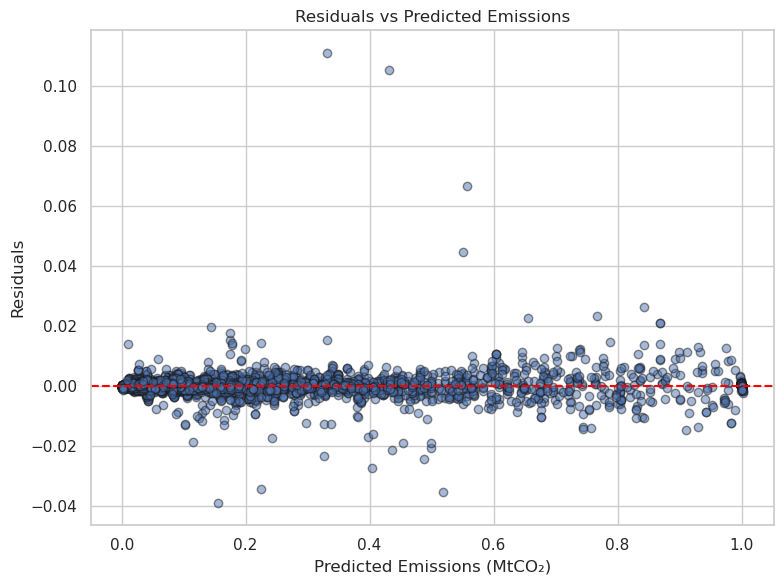

In [513]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Emissions")
plt.xlabel("Predicted Emissions (MtCO₂)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.savefig("eda_charts/residuals_vs_predicted.png", dpi=300)
plt.show()


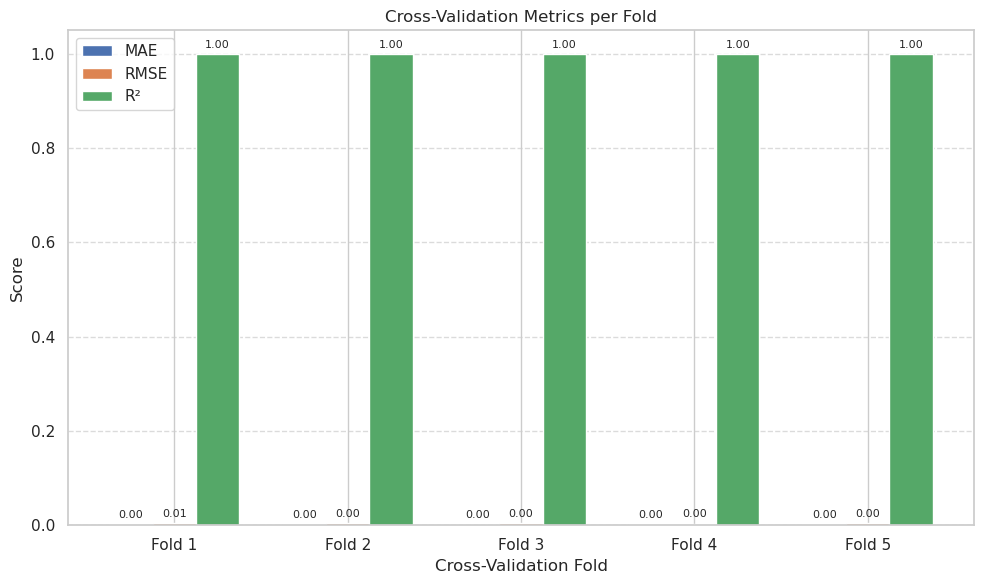

In [516]:
# === Cross-Validation Metrics Chart ===
folds = [f'Fold {i+1}' for i in range(len(mae_scores))]
x = np.arange(len(folds))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, mae_scores, width, label='MAE')
ax.bar(x, rmse_scores, width, label='RMSE')
ax.bar(x + width, r2_scores, width, label='R²')

# Annotate bars with values
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Cross-Validation Fold')
ax.set_ylabel('Score')
ax.set_title('Cross-Validation Metrics per Fold')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.savefig('eda_charts/figure_40_crossval_metrics_chart.png', dpi=300)
plt.show()


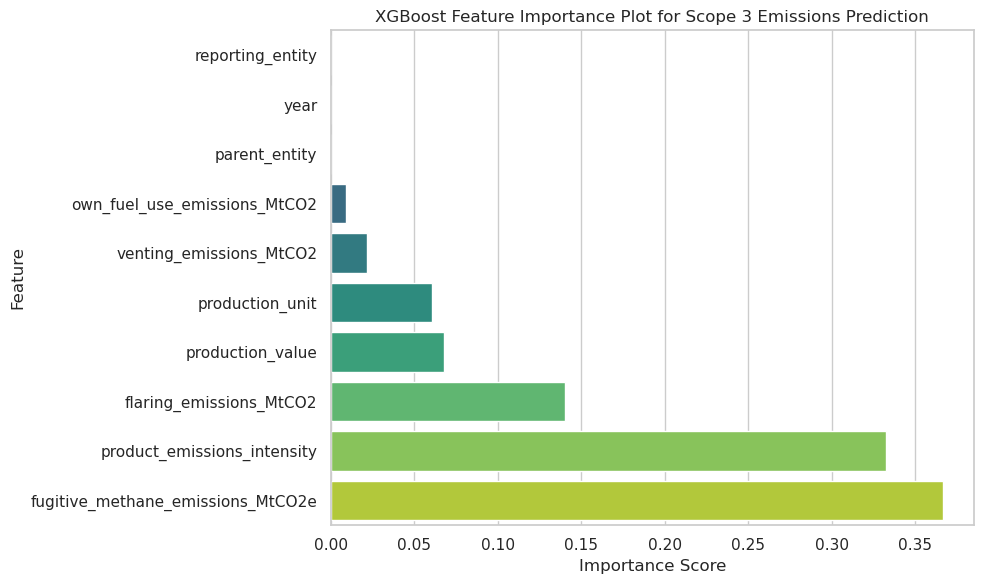

In [523]:
importances = xgb_model.feature_importances_
features = feature_cols  # These come the model training function
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot top 10 features
top_n = 10
top_features = importance_df.tail(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=top_features,
    palette='viridis',
    dodge=False,
    legend=False  # suppress legend since hue duplicates the y-axis
)
plt.title("XGBoost Feature Importance Plot for Scope 3 Emissions Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("eda_charts/xgb_feature_importance.png", dpi=300)
plt.show()

In [525]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_val)

# SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_val, show=False, plot_type="bar")
plt.title("SHAP Summary Plot of Feature Importance")
plt.tight_layout()
plt.savefig("eda_charts/shap_summary_plot.png", dpi=300)
plt.close()
